In [2]:
from coredotfinance.data import KrxReader
import pandas as pd
import numpy as np
import requests
import lxml
from bs4 import BeautifulSoup
from requests import Response
import re
import matplotlib.pyplot as plt

In [3]:
krx = KrxReader()
company_df = krx.listed_company()
dataframe = krx.read_date('2022-07-01', kor=True)

In [ ]:

headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'}

url_upjong = "https://finance.naver.com/sise/sise_group.naver?type=upjong"
res = requests.get(url_upjong, headers=headers)
page_soup = BeautifulSoup(res.text, "lxml")
summary_html = page_soup.select('td a')

upjong_list = pd.DataFrame(re.findall('no=(.+?)">(.+?)</a>',str(summary_html)))
upjong_list = upjong_list.rename(columns={0:"no",1:"upjong"}).sort_values(by=['upjong']).reset_index(drop=True)
upjong_list.no = upjong_list.no.str.zfill(3)

request_upjong_url = "https://finance.naver.com/sise/field_submit.naver?menu=upjong&returnUrl=http%3A%2F%2Ffinance.naver.com%2Fsise%2Fsise_group_detail.naver%3Ftype%3Dupjong%26no%3D"
request_url1 = "&fieldIds=market_sum&fieldIds=property_total&fieldIds=debt_total&fieldIds=sales"
request_url2 = "&fieldIds=operating_profit&fieldIds=net_income&fieldIds=eps&fieldIds=dividend"
#request_url3 = "&fieldIds=per&fieldIds=roe&fieldIds=roa&fieldIds=listed_stock_cnt&fieldIds=pbr&fieldIds=reserve_ratio"

upjong = pd.DataFrame()
for i in (upjong_list['no'].to_list()):
    temp = pd.DataFrame()
    for j in ([request_url1,request_url2]):
        res = requests.get(request_upjong_url+i+j, headers=headers)
        page_soup = BeautifulSoup(res.text, "lxml")
        upjong_data_html = page_soup.select_one('#contentarea > div:nth-child(5)')
        col = [item.get_text().strip() for item in upjong_data_html.select('thead th')]
        col = [x for x in col if x not in ['종목명','토론실']]
        row = [item.get_text().strip() for item in upjong_data_html.select('tbody a')]
        row = list(filter(None,row))
        num = np.array([item.get_text().strip() for item in upjong_data_html.select('td.number')])
        num.resize(len(row),len(col))
        df = pd.DataFrame(num, columns=col,index=row).drop(columns=['현재가','전일비','등락률'])
        df['Sector'] = upjong_list[upjong_list.no==i].upjong.iat[0]
        temp = pd.concat([temp,df], axis = 1)
    #temp.index = pd.MultiIndex.from_product([[upjong_list[upjong_list.no==i].upjong.iat[0]],temp.index],names=["Sector","Stock"])
    upjong = pd.concat([upjong,temp], axis = 0)
    
with pd.ExcelWriter('upjong.xlsx', engine='openpyxl') as writer:
    upjong.to_excel(writer)

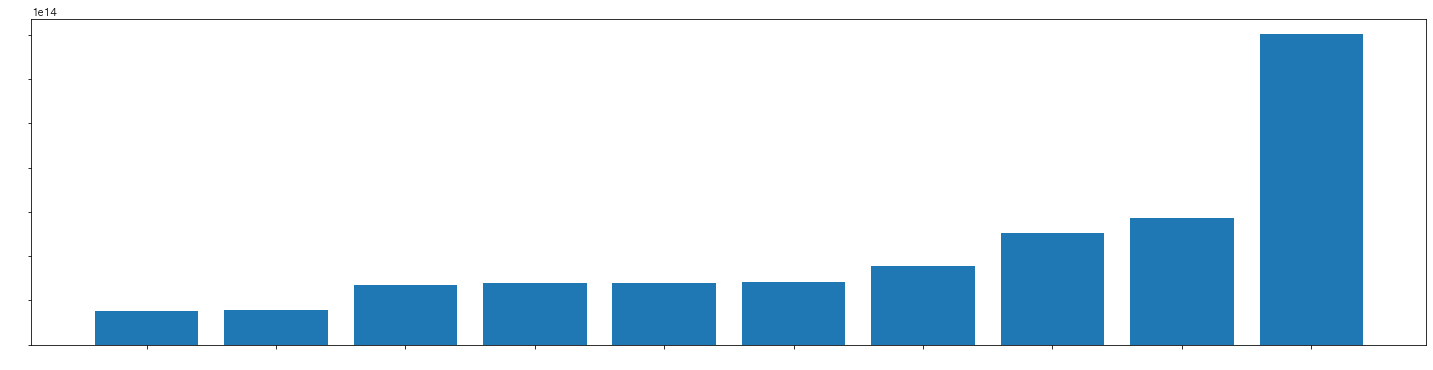

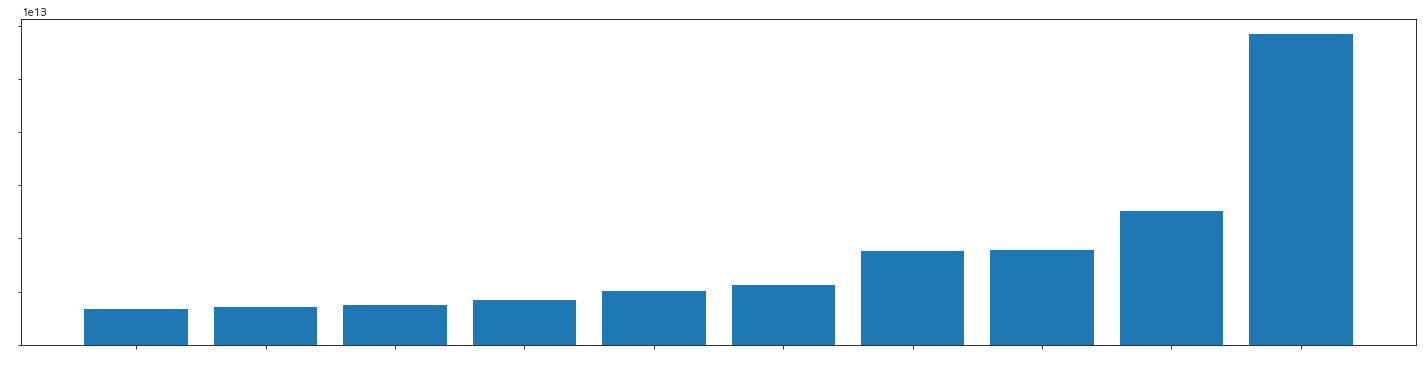

In [23]:
listed_company_df = pd.merge(company_df, dataframe, on='종목코드', how='inner')
filtered_companies = listed_company_df[['종목명_x', '시장구분_x', '업종명', '상장주식수_x','업종코드', '시가총액']]

#KOSPI
KOSPI_companies = filtered_companies[filtered_companies['시장구분_x']=="KOSPI"].sort_values(by=['시가총액'])
KOSPI_companies = KOSPI_companies.loc[KOSPI_companies['시가총액'] < 10**15] 

KOSPI_groupby_sum = KOSPI_companies.groupby('업종명')['시가총액'].agg(시가총액='sum', MyCount='count').sort_values(by=['시가총액'])
KOSPI_groupby_mean = KOSPI_companies.groupby('업종명').mean().sort_values(by=['시가총액'])

KOSPI_groupby_sum = KOSPI_groupby_sum[-10:]
KOSPI_groupby_mean = KOSPI_groupby_mean[-10:]

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['text.color'] = 'white'
plt.rcParams["figure.figsize"] = (25,6)
plt.xticks(color='w')
plt.yticks(color='w')


plt.bar(KOSPI_groupby_sum.index.to_list(), KOSPI_groupby_sum['시가총액'].to_list())
plt.show()

plt.bar(KOSPI_groupby_mean.index.to_list(), KOSPI_groupby_mean['시가총액'].to_list())
plt.xticks(color='w')
plt.yticks(color='w')
plt.show()
#plt.hist(KOSPI_groupby_sum['매출액'].to_list())

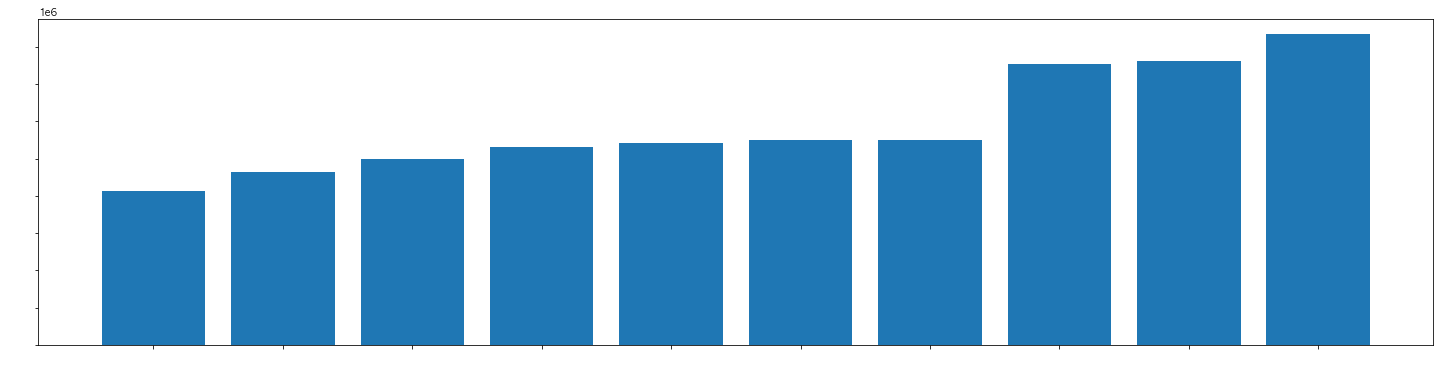

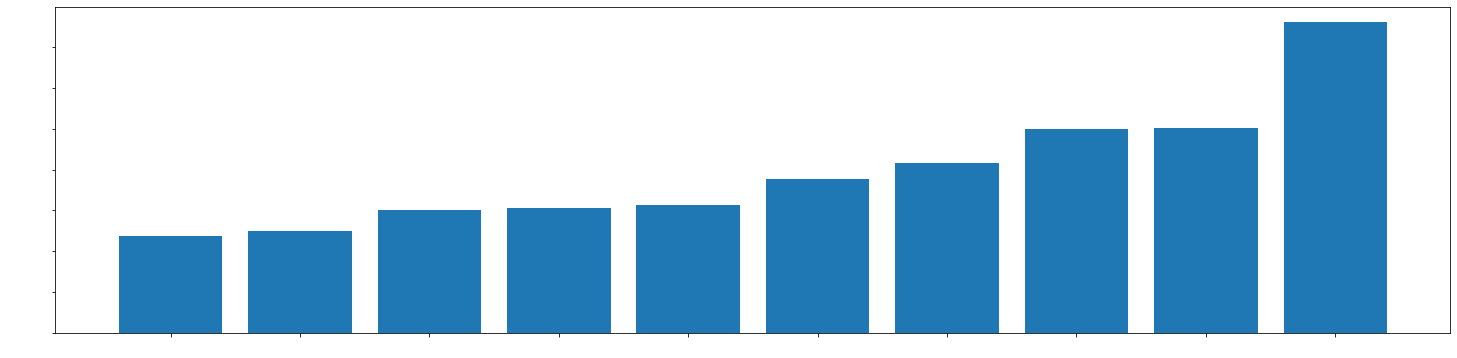

In [18]:

upjong = pd.read_excel('upjong_merged.xlsx', engine='openpyxl')

filtered_companies = upjong[['종목명', '시장구분', '영업이익', '시가총액', 'Sector','매출액']]

KOSPI_companies = filtered_companies[filtered_companies['시장구분'] == "KOSPI"]

KOSPI_companies = KOSPI_companies.apply(lambda x: x.str.replace(',', ''))
KOSPI_companies['영업이익'] = pd.to_numeric(KOSPI_companies['영업이익'])
KOSPI_companies['매출액'] = pd.to_numeric(KOSPI_companies['매출액'])

KOSPI_companies = KOSPI_companies.dropna()
KOSPI_companies = KOSPI_companies.sort_values(by=['매출액'])
#KOSPI_companies = KOSPI_companies.loc[KOSPI_companies['매출액'] < 10**6] 


KOSPI_groupby_sum = KOSPI_companies.groupby('Sector')['매출액'].agg(매출액='sum').sort_values(by=['매출액'])#,  MyCount='count'
KOSPI_groupby_mean = KOSPI_companies.groupby('Sector')['매출액'].agg(매출액='mean').sort_values(by=['매출액'])#,  MyCount='count'

KOSPI_groupby_sum = KOSPI_groupby_sum[-10:]
KOSPI_groupby_mean = KOSPI_groupby_mean[-10:]

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['text.color'] = 'white'
plt.rcParams["figure.figsize"] = (25,6)
plt.xticks(color='w')
plt.yticks(color='w')


plt.bar(KOSPI_groupby_sum.index.to_list(), KOSPI_groupby_sum['매출액'].to_list())
plt.show()

plt.bar(KOSPI_groupby_mean.index.to_list(), KOSPI_groupby_mean['매출액'].to_list())
plt.xticks(color='w')
plt.yticks(color='w')
plt.show()